# Pronóstico adaptativo

## Descripción del problema real

Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

## Descripción del problema en términos de los datos

La carpeta `datos/precios/` contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

## Aproximaciones posibles

En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

## Requerimientos

Usted debe:

* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


## Solucion

In [29]:
import glob
files = []
for f in glob.glob('datos/precios/*'):
    files.append(f)

In [30]:
import pandas as pd
final_p = pd.read_excel(files[0],skiprows=3)

In [31]:
for i in range (1,len(files)):
    count = 0
    while(True):
        price = pd.read_excel(files[i],skiprows=count).iloc[:,0:25]
        
        if price.columns[0]=='Fecha':
            break
        elif count>=15:
            break
        else:
            count+=1
    final_p = pd.concat([final_p,price],ignore_index=True,axis=0)

In [32]:
final_p['Fecha']=pd.to_datetime(final_p['Fecha'])

In [33]:
final_p = final_p.sort_values(by=['Fecha'])

In [34]:
serie = pd.concat([final_p['Fecha'],final_p.mean(axis=1)],axis=1)
serie = serie.dropna()
serie = serie.reset_index(drop=True)
serie.columns = ["date","price"]

In [35]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range =(0,1))
dataScaled = scaler.fit_transform(serie['price'].values.reshape(-1,1)).reshape(-1,)

### Adaline

In [8]:
import tensorflow as tf
tf.enable_eager_execution()

C:\Users\jfmdd\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [25]:
import numpy as np
class Model(object):
    def __init__(self, L):
        self.w = tf.contrib.eager.Variable([0.0]*(L))
    
    def __call__(self,x):
        x= tf.constant(np.array([1.0]+x, dtype=np.float32))
        y_pred = tf.reduce_sum(tf.multiply(self.w,x))
        return y_pred
    
    def fit(self, mu,x,y_desired):
        y_pred = self(x)
        e = y_desired-y_pred
        x = tf.constant(np.array([1.0]+x, dtype=np.float32))
        self.w.assign_add(tf.scalar_mul(2*mu*e,x))
        

In [43]:
retardos = []
for i in range(0,11):
    model = Model(i)
    y_pred = np.empty(len(dataScaled))
    y_pred[:]=np.nan
    for t in range(i, len(dataScaled)):
        x=dataScaled[t-i:t]
        y_pred[t]=model(x)
        model.fit(mu=0.05,x=x,y_desired=dataScaled[t])
    retardos.append([dataScaled[-(168):],y_pred[-(168):]])

In [44]:
retardos

[[array([0.06179415, 0.05366883, 0.05705604, 0.05602818, 0.06212981,
         0.05206928, 0.049846  , 0.04276502, 0.04447265, 0.04603823,
         0.04505787, 0.04535902, 0.0429107 , 0.04123286, 0.03901942,
         0.03704483, 0.03961932, 0.04008434, 0.04152692, 0.04174808,
         0.04367697, 0.04383486, 0.04664954, 0.04361531, 0.045623  ,
         0.04279563, 0.03950133, 0.04190543, 0.03946949, 0.04684907,
         0.04590589, 0.05197916, 0.05479285, 0.05846783, 0.05958722,
         0.0623181 , 0.06476314, 0.07148774, 0.07417756, 0.07333105,
         0.07465606, 0.0836521 , 0.07742028, 0.06205989, 0.06993112,
         0.06927352, 0.07402254, 0.06997333, 0.06993579, 0.06824857,
         0.06773941, 0.06885603, 0.06890112, 0.06908818, 0.06844742,
         0.06747826, 0.06630636, 0.05871199, 0.06460717, 0.06201082,
         0.06228103, 0.06261111, 0.05975259, 0.04820405, 0.06056713,
         0.05915364, 0.05797395, 0.05853814, 0.05775555, 0.06166131,
         0.05920985, 0.06190715, 0

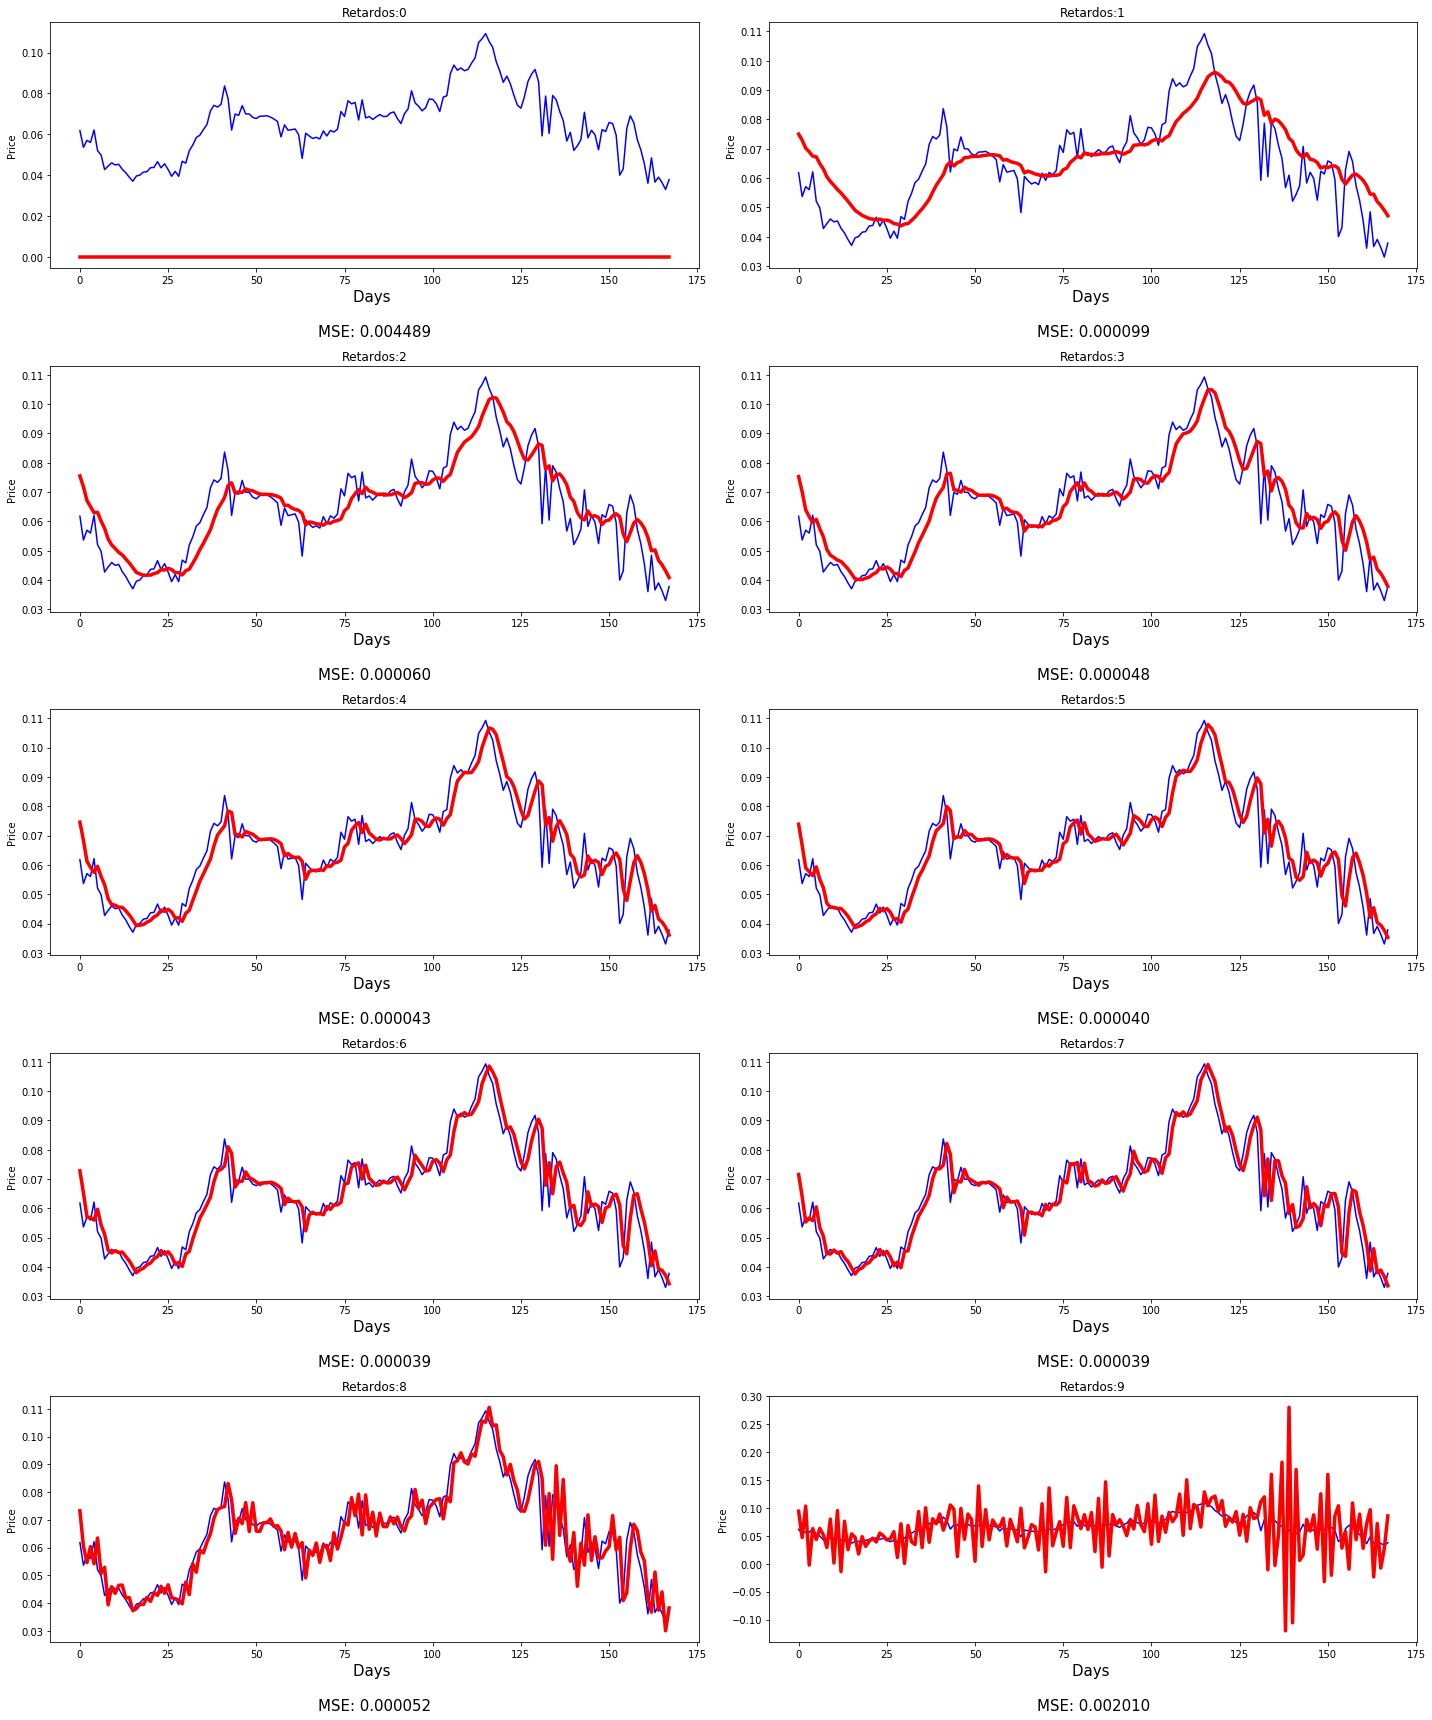

In [46]:
import matplotlib.pyplot as plt
from sklearn import metrics

fig, axes =plt.subplots (nrows=5,ncols=2,figsize=(20,24))

count = 0
for row in axes:
    for x in row:
        rReal = retardos[count][0]
        rPred = retardos[count][1]
        x.plot(rReal, color = 'blue', label = 'real')
        x.plot(rPred,color = 'red', label = 'predicted', linewidth=3.5)
        
        x. set_xlabel('Days \n \n'+str('MSE: '+'{:f}'.format(metrics.mean_squared_error(rReal,rPred))), fontsize = 15)
        x.set_ylabel ('Price')
        x.set_title(str('Retardos:'+ str(count)))
        
        fig
        plt.tight_layout()
        count+=1

El numero de retardos optimos puede ser 6 o 7

In [57]:
learnRateTest = [0.01, 0.02,0.03,0.04,0.05,0.06,0.07,0.08]

learnRateRes = []
for i in range(len(learnRateTest)):
    L = 7
    model = Model(L)
    y_pred = np.empty(len(dataScaled))
    y_pred[:]=np.nan
    for t in range(L, len(dataScaled)):
        x=dataScaled[t-L:t]
        y_pred[t]=model(x)
        model.fit(mu=learnRateTest[i],x=x,y_desired=dataScaled[t])
    learnRateRes.append([dataScaled[-(168):],y_pred[-(168):]])

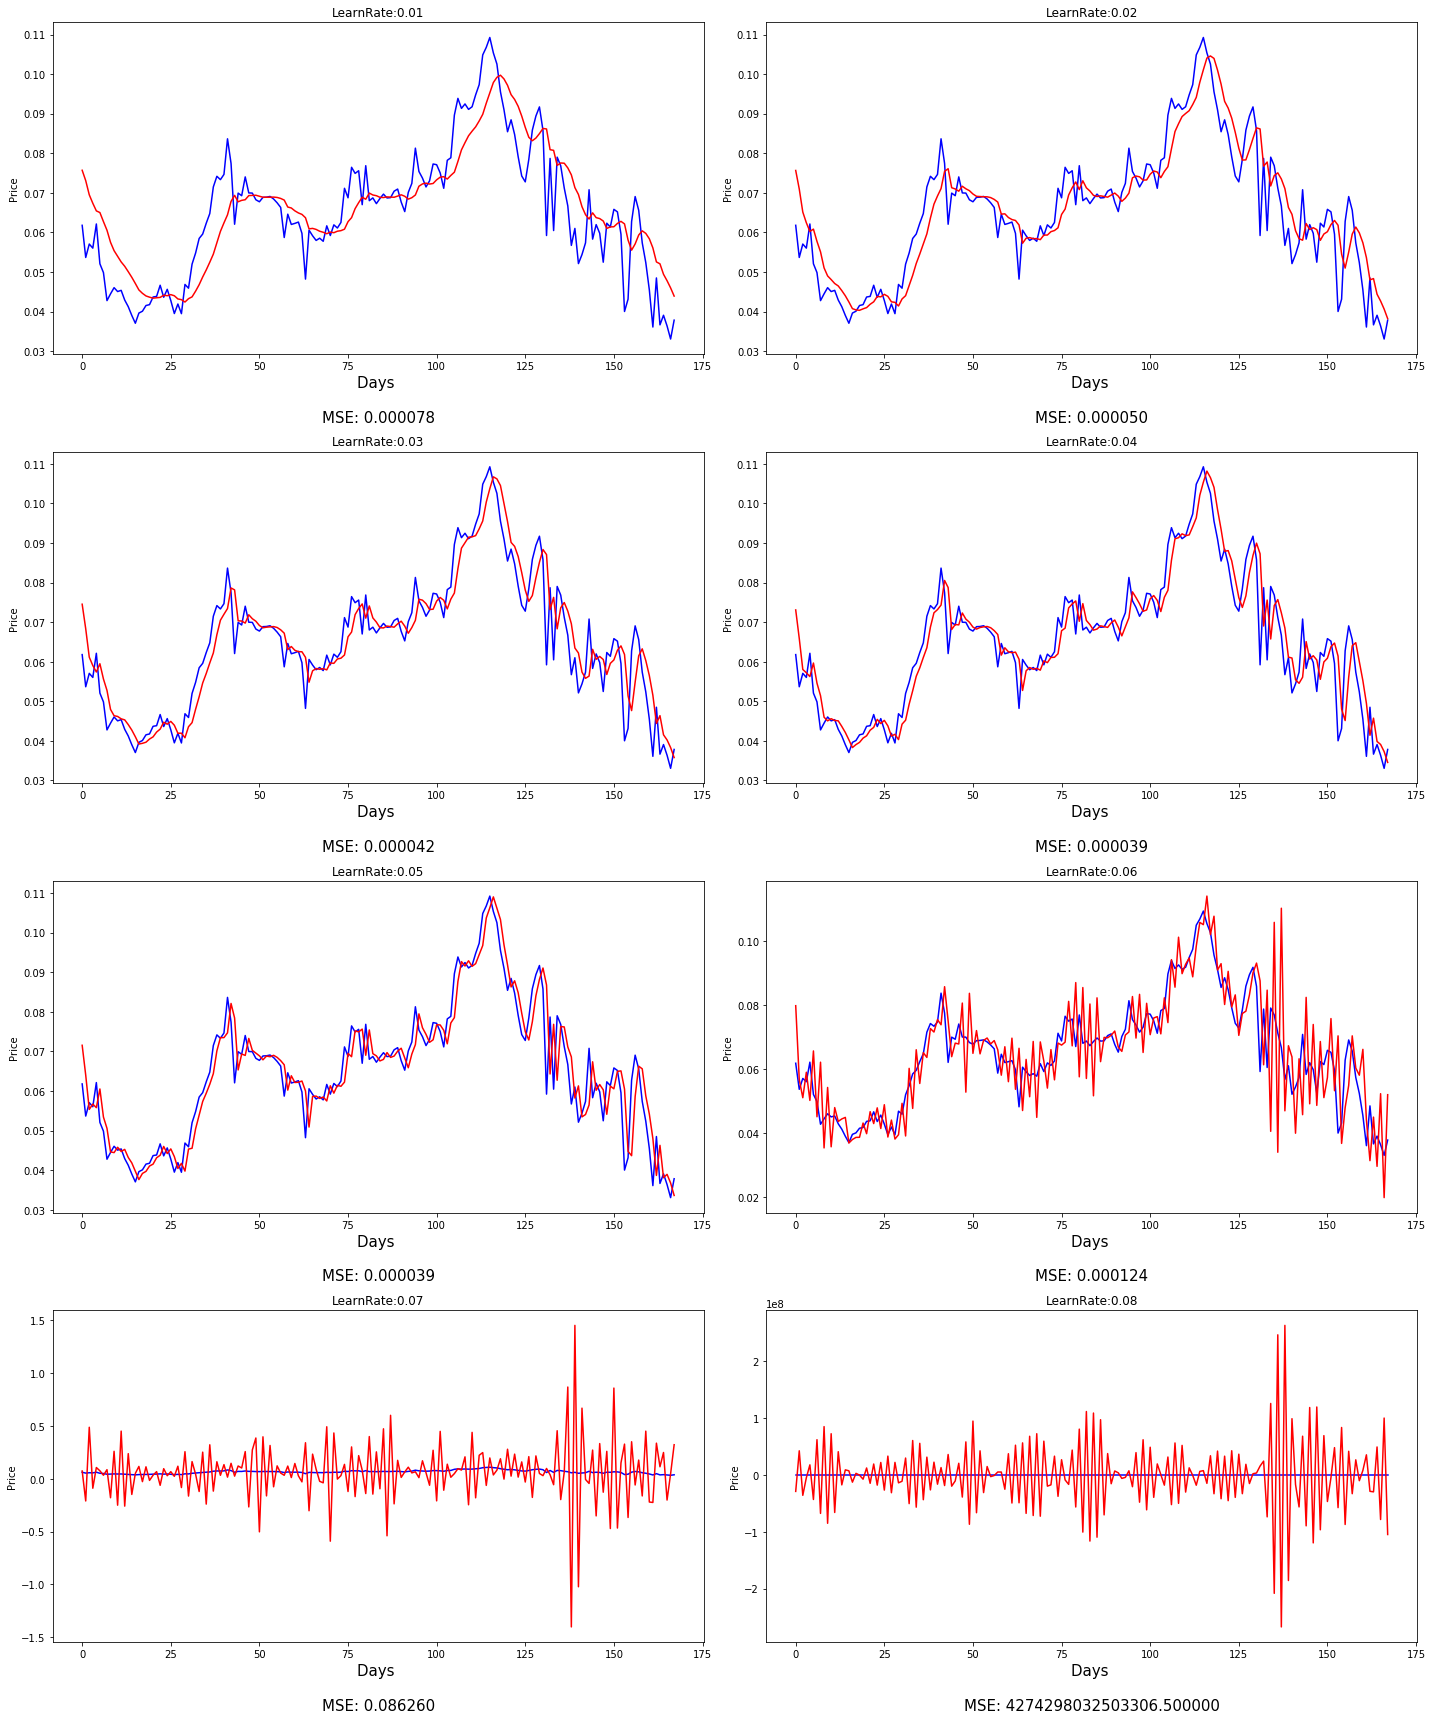

In [58]:
import matplotlib.pyplot as plt
from sklearn import metrics

fig, axes =plt.subplots (nrows=4,ncols=2,figsize=(20,24))

count = 0
for row in axes:
    for x in row:
        rlReal = learnRateRes[count][0]
        rlPred = learnRateRes[count][1]
        x.plot(rlReal, color = 'blue', label = 'real')
        x.plot(rlPred,color = 'red', label = 'predicted')
        
        x. set_xlabel('Days \n \n'+str('MSE: '+'{:f}'.format(metrics.mean_squared_error(rlReal,rlPred))), fontsize = 15)
        x.set_ylabel ('Price')
        x.set_title(str('LearnRate:'+ str(learnRateTest[count])))
        
        fig
        plt.tight_layout()
        count+=1

Con un learn rate de 0.05 o 0.04 seria la tasa de aprendisaje adecuada

entonces el modelo quedaria asi:

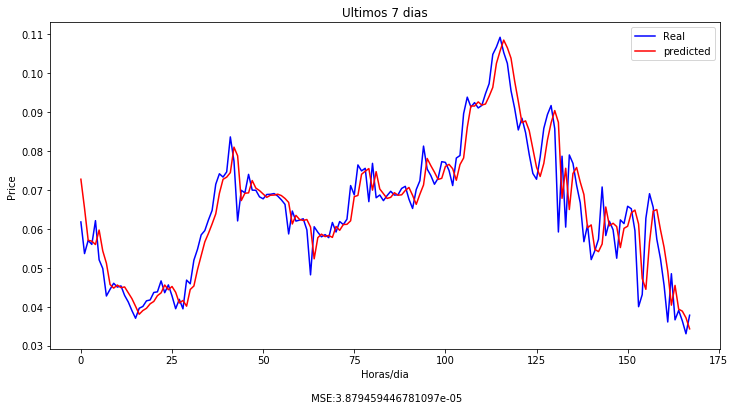

In [63]:
def completeOptimalModel(L, learnRate, data, days):
    model = Model(L)
    
    y_pred = np.empty(len(dataScaled))
    y_pred[:]=np.nan
    for t in range(L, len(dataScaled)):
        x=dataScaled[t-L:t]
        y_pred[t]=model(x)
        model.fit(mu=learnRate,x=x,y_desired=dataScaled[t])
    return[dataScaled[-(days):],y_pred[-(days):]]

completeModel = completeOptimalModel(6,0.05,dataScaled,24*7)

plt.figure(figsize = (12,6))
plt.plot(completeModel[0], color = 'blue', label = 'Real')
plt.plot(completeModel[1], color = 'red',label='predicted')
plt.title ('Ultimos 7 dias')
plt.xlabel ('Horas/dia\n \n '+ 'MSE:'+str(metrics.mean_squared_error(completeModel[0],completeModel[1])))
plt.ylabel ('Price')
plt.legend()
plt.show()
                                    